Suppose we generate data from a mixture of exponentials with no censoring (this could be extended to censoring, but for our application we don't observe censoring). Furthermore, the data is not observed directly, but our instrument has binned the data into integer buckets. For example, the actual value is 4.3, but our instrument's resolution is too poor to measure the decimal point. So 4.3 goes into the "4.x" bucket. 

This model is easy to handle in *lifelines*. Instead of worrying about the binning, we can treat the system as an interval-censoring problem. That is, if an observation landed in the $i$th bin, then we know the _true_ data point occured somewhere between the $i$th and $i+1$th bin. This is precisely interval censoring. 

We can use *lifelines* custom model semantics to create a mixture model as well. The true model is:

$$S(t) = p \exp\left(-\frac{t}{\lambda_1}\right) + (1-p)\exp\left(-\frac{t}{\lambda_2}\right)$$

Therefore the cumulative hazard is:

$$H(t) = -\log(S(t)) = -\log\left(p \exp\left(-\frac{t}{\lambda_1}\right) + (1-p)\exp\left(-\frac{t}{\lambda_2}\right)\right) $$

In [1]:
from numpy.random import exponential
from lifelines.fitters import ParametricUnivariateFitter
import autograd.numpy as np
np.random.seed(10)

In [2]:
T = [exponential(20) for _ in range(10000)] + [exponential(40) for _ in range(500)]
counts_obs = np.bincount(T)
T_obs = np.arange(np.amax(T))

(0.0, 100.0)

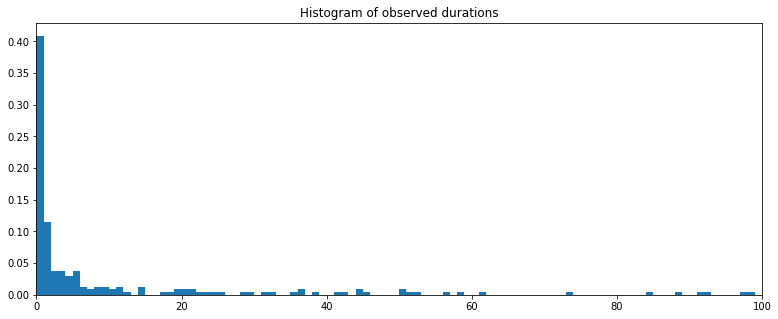

In [3]:
plt.figure(figsize=(13,5))
plt.hist(counts_obs, bins=T_obs, density=True)
plt.title("Histogram of observed durations")
plt.xlim(0, 100)

In [4]:
# To help the model avoid the "non-identibility" problem, we can set the *upper* bound of the first lambda to be 
# the average of the observed data, and the *lower* bound of the second lambda to the same value. Why? 
# We'd like to partition the postive reals into two halves, each containing one of the lambdas. The sample
# mean of the data is v = p * lambda1 + (1-p) * lambda2, which has the property lambda1 < v < lambda2, therefore  
# it will partition the space correctly. 
mean_obs = np.average(T_obs, weights=counts_obs)
print(mean_obs)

20.015428571428572


In [5]:
class MixtureExponential(ParametricUnivariateFitter):

    _fitted_parameter_names = ['lambda1', 'lambda2', 'p']
    _bounds = [(0, mean_obs), (mean_obs, None), (0, 1)]

    def _cumulative_hazard(self, params, t):
        l1, l2, p = params
        return -np.log(p * np.exp(-t / l1) + (1-p) * np.exp(-t / l2))


model = MixtureExponential()
model.fit_interval_censoring(
    lower_bound=T_obs, 
    upper_bound=T_obs + 1, 
    weights=counts_obs, 
    initial_point=np.array([mean_obs / 2, mean_obs * 2, 0.5])
)

model.print_summary()

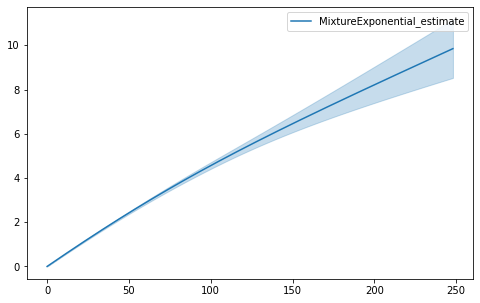

In [6]:
model.plot_cumulative_hazard(figsize=(8,5))